# 1. Initialization

In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter, distance_transform_edt, binary_dilation
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Set random seed for reproducibility
np.random.seed(42)

# 2. Importing North America Map

In [3]:
# Define the grid dimensions
LAT_SIZE = 300
LON_SIZE = 400

# Spatial grid - lat goes from [0, 60], lon from [-160, -80]
lat_range = np.linspace(0, 60, LAT_SIZE)
lon_range = np.linspace(-160, -80, LON_SIZE)

# Create meshgrid - LAT corresponds to rows (y) and LON to columns (x)
LON, LAT = np.meshgrid(lon_range, lat_range)

# 3. Environment Initialisation

## 3.1 Generating Sea Surface Temperature Data

Sea surface temperature data, SST, is modeled as

$SST = 25 - 0.2 \times (LAT - 20) + \epsilon, \quad \epsilon \sim N(0, 0.8)$



In [4]:
# Create realistic SST data
def generate_sst_data():
    # Base SST decreases with latitude
    sst_base = 25 - 0.2 * (LAT - 20)

    # Add random variations
    random_variation = np.random.normal(0, 0.8, size=sst_base.shape)
    smooth_variation = gaussian_filter(random_variation, sigma=5.0)

    # Add coastal upwelling effect (cooler waters near coast)
    # Approximate distance from coast
    coast_distance = np.abs(LON + 124)  # Approximate West Coast longitude
    coastal_effect = -2 * np.exp(-0.5 * coast_distance)

    # Add seasonal fluctuation
    seasonal_effect = 2 * np.sin(np.pi * LAT / 60)

    # Combine effects
    sst = sst_base + smooth_variation + coastal_effect + seasonal_effect

    return sst

def create_land_mask():
    """Create a land mask with better performance using shapely prepared geometries."""
    # Initialize with False (water everywhere)
    land_mask = np.zeros((LAT_SIZE, LON_SIZE), dtype=bool)

    # Get cartopy's land feature
    land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m')

    # Flatten coordinates for faster processing
    points = np.vstack([LON.flatten(), LAT.flatten()]).T

    # Process points in batches for better performance
    result = np.zeros(points.shape[0], dtype=bool)

    # Import for prepared geometries
    from shapely.prepared import prep

    # Process each geometry
    for geom in land_feature.geometries():
        # Create a prepared geometry for faster operations
        prepared_geom = prep(geom)

        # Process in smaller batches to avoid memory issues
        batch_size = 10000
        for i in range(0, len(points), batch_size):
            batch_points = points[i:i+batch_size]
            # Check each point individually but in a batch-optimized way
            for j, point in enumerate(batch_points):
                if prepared_geom.contains(Point(point[0], point[1])):
                    result[i+j] = True

    # Reshape result back to grid
    land_mask = result.reshape(LAT_SIZE, LON_SIZE)

    return land_mask

# Create the land mask
land_mask = create_land_mask()

# Generate SST data
sst = generate_sst_data()

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


## 3.2 Generating Krill Density Data

In [5]:
def generate_krill_density(sst, land_mask):

    """
    Generate realistic krill density with patches heavily concentrated near coastline
    and increasing with latitude (denser at higher latitudes, almost none at equator).

    Parameters:
    sst (numpy.ndarray): Sea surface temperature array
    land_mask (numpy.ndarray): Binary mask where 1 indicates land, 0 indicates ocean

    Returns:
    numpy.ndarray: Krill density field (0-1 range)
    """

    # Initialize with very small background density
    background_density = 0.01
    krill_density = np.ones((LAT_SIZE, LON_SIZE)) * background_density

    # Create ocean mask (1 for ocean, 0 for land)
    ocean_mask = 1 - land_mask

    # Get coastline using CartoPy method
    # First get the precise coastline using cartopy's NaturalEarthFeature
    coastline_feature = cfeature.NaturalEarthFeature('physical', 'coastline', '10m')

    # Create a coastline mask based on a higher resolution coastline
    coastline_mask = np.zeros((LAT_SIZE, LON_SIZE), dtype=bool)

    # Create a figure and axis with cartopy projection to access coastline
    # This is a temporary figure just used to get coastline data
    temp_fig = plt.figure(figsize=(1, 1))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-160, -80, 0, 60])

    # Get coastline geometries
    for geom in coastline_feature.geometries():
        if geom.is_valid:
            # Extract coastline coordinates within our domain
            xy = np.array(geom.coords)
            for point in xy:
                lon, lat = point[0], point[1]
                if (-160 <= lon <= -80) and (0 <= lat <= 60):
                    # Find closest grid point
                    lat_idx = np.abs(lat_range - lat).argmin()
                    lon_idx = np.abs(lon_range - lon).argmin()

                    # Mark as coastline in a 3x3 neighborhood for a thicker coastline
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            ni, nj = lat_idx + di, lon_idx + dj
                            if 0 <= ni < LAT_SIZE and 0 <= nj < LON_SIZE and ocean_mask[ni, nj]:
                                coastline_mask[ni, nj] = True

    # Clean up temporary figure
    plt.close(temp_fig)

    # For cells not marked as coastline, compute distance to nearest coastline point
    distance_from_coast = distance_transform_edt(~coastline_mask) * ocean_mask

    # Create a steep decay function from the coastline (stronger concentration)
    decay_rate = 0.8  # Higher value = more concentrated near coast

    # Normalize distances
    max_distance = np.max(distance_from_coast[ocean_mask == 1])
    if max_distance > 0:  # Avoid division by zero
        # Create exponential decay - steeper decay means higher concentration near coast
        coast_proximity = np.exp(-decay_rate * distance_from_coast / max_distance) * ocean_mask
    else:
        coast_proximity = ocean_mask

    # Create a grid for distance calculations
    y_grid, x_grid = np.mgrid[0:LAT_SIZE, 0:LON_SIZE]

    # Create a latitude effect (increases with latitude)
    # This creates a gradient where higher latitudes have more krill
    # Use actual latitude values for a realistic gradient
    # Get a 2D grid of latitude values
    lat_grid = np.zeros((LAT_SIZE, LON_SIZE))
    for i in range(LAT_SIZE):
        lat_grid[i, :] = lat_range[i]

    # Latitude effect: custom function that maintains similar densities between 30-50°
    # and gradually decreases to near zero at the equator
    # First normalize latitude to 0-1 range
    norm_lat = lat_grid / 60.0

    # Create a more gradual transition that:
    # - Maintains similar values between 30-50° (0.5-0.83 in normalized range)
    # - Gradually decreases from 30° to 0°
    # - Slightly increases from 50° to 60°
    lat_effect = np.zeros_like(norm_lat)

    # For latitudes below 30° (0.5 normalized): gradual increase
    below_30 = norm_lat < 0.5
    lat_effect[below_30] = 0.1 + 0.9 * (norm_lat[below_30] / 0.5) ** 1.5

    # For latitudes between 30-50° (0.5-0.83 normalized): plateau
    between_30_50 = (norm_lat >= 0.5) & (norm_lat < 0.83)
    lat_effect[between_30_50] = 1.0

    # For latitudes above 50° (0.83 normalized): slight increase
    above_50 = norm_lat >= 0.83
    lat_effect[above_50] = 1.0 + 0.2 * ((norm_lat[above_50] - 0.83) / 0.17)

    # Number of patches varies with latitude
    # More patches at higher latitudes, fewer at lower latitudes
    base_num_patches = 80

    # Vary the number of patches based on "latitude bands"
    # Define latitude bands with revised distribution
    lat_bands = [0, 15, 30, 50, 60]
    # New weights: very few at 0-15°, more at 15-30°, and similar amounts at 30-50° and 50-60°
    band_weights = [0.1, 0.4, 0.95, 1.0]  # Multipliers for each band

    # For each latitude band, create appropriate number of patches
    for i in range(len(lat_bands) - 1):
        # Get indices for this latitude band
        band_start = np.abs(lat_range - lat_bands[i]).argmin()
        band_end = np.abs(lat_range - lat_bands[i+1]).argmin()

        # Calculate number of patches for this band
        num_patches = int(base_num_patches * band_weights[i])

        for _ in range(num_patches):
            # Use rejection sampling to place patches very close to coastline
            patch_placed = False
            coastal_threshold = 0.9  # High threshold to ensure patches are close to coast

            for attempt in range(100):
                # Generate position within this latitude band
                lat_idx = np.random.randint(band_start, band_end)
                lon_idx = np.random.randint(0, LON_SIZE)

                # Only accept points that are:
                # 1. In ocean (not land)
                # 2. Very close to coastline (high coast_proximity value)
                if (not land_mask[lat_idx, lon_idx] and
                    coast_proximity[lat_idx, lon_idx] > coastal_threshold):
                    patch_placed = True
                    break

            if not patch_placed:
                # If we couldn't place a patch after many attempts, try again with lower threshold
                for attempt in range(50):
                    lat_idx = np.random.randint(band_start, band_end)
                    lon_idx = np.random.randint(0, LON_SIZE)

                    if (not land_mask[lat_idx, lon_idx] and
                        coast_proximity[lat_idx, lon_idx] > 0.7):
                        patch_placed = True
                        break

            if patch_placed:
                # Smaller patch size for tighter clustering
                # Make patches larger at higher latitudes
                base_patch_size = np.random.uniform(2, 8)
                patch_size = base_patch_size * (1 + 0.5 * lat_effect[lat_idx, lon_idx])

                # Patch intensity higher near coast and at higher latitudes
                base_intensity = 0.7
                lat_intensity_boost = 0.3 * lat_effect[lat_idx, lon_idx]
                max_intensity = base_intensity + 0.3 * coast_proximity[lat_idx, lon_idx] + lat_intensity_boost

                # Calculate distance from center - using grid coordinates
                distance = np.sqrt((y_grid - lat_idx)**2 + (x_grid - lon_idx)**2)

                # Create circular patch with Gaussian falloff
                patch = max_intensity * np.exp(-(distance**2) / (2 * patch_size**2))

                # Apply ocean mask to ensure no krill on land
                patch = patch * ocean_mask

                # Add patch to krill density (take maximum to avoid overwriting existing patches)
                krill_density = np.maximum(krill_density, patch)

    # Make krill density inversely related to SST (prefer cooler waters)
    # Normalize SST to 0-1 range for this calculation
    sst_min, sst_max = np.min(sst), np.max(sst)
    if sst_max > sst_min:  # Avoid division by zero
        sst_norm = (sst - sst_min) / (sst_max - sst_min)
        cold_water_effect = 0.3 * (1 - sst_norm)
    else:
        cold_water_effect = np.zeros_like(sst)

    # Add a very strong coastal upwelling effect (higher productivity near coast)
    coastal_upwelling = 0.9 * coast_proximity

    # Combine effects: patch-based density, temperature effect, coastal proximity, and latitude effect
    krill_density = (0.25 * krill_density +        # Patch-based density
                     0.15 * cold_water_effect * ocean_mask +  # Temperature effect
                     0.4 * coastal_upwelling +     # Coastal upwelling
                     0.2 * lat_effect * ocean_mask)  # Latitude gradient effect

    # Apply additional non-linear enhancement to further concentrate near coastline
    # This creates a stronger falloff away from the coast
    krill_density = krill_density * (coast_proximity ** 0.5)

    # Apply latitude gradient again with a gentler transition to ensure a more gradual decrease toward equator
    # This ensures some minimal density even at low latitudes (not completely zero)
    krill_density = krill_density * (0.15 + 0.85 * lat_effect)

    # Ensure zero krill density on land
    krill_density = krill_density * ocean_mask

    # Normalize to 0-1 range
    max_density = np.max(krill_density)
    if max_density > 0:  # Avoid division by zero
        krill_density = krill_density / max_density

    return krill_density

In [6]:
# Generate krill density
krill_density = generate_krill_density(sst, land_mask)

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


## 3.3 Functions to retrieve generated data

In [7]:
# Functions to access data at specific coordinates
def get_sst_at_coordinates(lat, lon):
    """Get SST value at specific latitude and longitude."""
    # Find closest indices
    lat_idx = np.abs(lat_range - lat).argmin()
    lon_idx = np.abs(lon_range - lon).argmin()

    # Ensure indices are in bounds
    lat_idx = np.clip(lat_idx, 0, LAT_SIZE-1)
    lon_idx = np.clip(lon_idx, 0, LON_SIZE-1)

    return sst[lat_idx, lon_idx]

def get_krill_at_coordinates(lat, lon):
    """Get krill density value at specific latitude and longitude."""
    # Find closest indices
    lat_idx = np.abs(lat_range - lat).argmin()
    lon_idx = np.abs(lon_range - lon).argmin()

    # Ensure indices are in bounds
    lat_idx = np.clip(lat_idx, 0, LAT_SIZE-1)
    lon_idx = np.clip(lon_idx, 0, LON_SIZE-1)

    return krill_density[lat_idx, lon_idx]


# 4. Whale class

In [8]:
# Whale class for simulation
class Whale:
    def __init__(self, initial_position, state=1, whale_id=None, north_to_south=True):
        self.position = np.array(initial_position)  # [lat, lon]
        self.state = state  # 1: transit, 2: forage
        self.path = [tuple(initial_position)]  # Store movement history
        self.states = [state]  # Store state history
        self.whale_id = whale_id
        self.north_to_south = north_to_south  # Direction of migration
        self.step_count = 0
        self.forage_count = 0
        self.total_krill_encountered = 0

    def move(self):
        """
        Update whale's position and state based on SST and krill density.
        """
        self.step_count += 1
        lat, lon = self.position

        # Get environmental data at current position
        sst_val = get_sst_at_coordinates(lat, lon)
        krill_val = get_krill_at_coordinates(lat, lon)

        # Accumulate krill encountered (only when foraging)
        if self.state == 2:
            self.total_krill_encountered += krill_val
            self.forage_count += 1

        # Compute probability of state change based on environmental conditions
        forage_prob = self.compute_forage_probability(sst_val, krill_val)

        # Update state (with some memory of previous state)
        prev_state_bias = 0.3  # Bias towards maintaining current state
        adjusted_prob = forage_prob if self.state == 1 else forage_prob + prev_state_bias
        adjusted_prob = np.clip(adjusted_prob, 0.1, 0.9)  # Ensure some probability of state change

        self.state = np.random.choice([1, 2], p=[1 - adjusted_prob, adjusted_prob])

        # Sample movement parameters from appropriate distributions
        if self.state == 1:  # Transit
            # Parameters for transit (shape=2.96, scale=7495.9 m ≈ 0.0675° at the equator)
            step_length = stats.gamma.rvs(2.96, scale=7495.9 / 111000)

            # Add directional bias based on migration direction
            if self.north_to_south:
                # Heading south: bias toward southern directions
                turning_angle = stats.vonmises.rvs(1.5, loc=3*np.pi/2)
            else:
                # Heading north: bias toward northern directions
                turning_angle = stats.vonmises.rvs(1.5, loc=np.pi/2)
        else:  # Foraging
            # Parameters for foraging (shape=1.17, scale=5376.6 m ≈ 0.0484° at the equator)
            step_length = stats.gamma.rvs(1.17, scale=5376.6 / 111000)
            turning_angle = stats.vonmises.rvs(0.3, loc=0)  # Less directed movement during foraging

        # Try to update position
        self.update_position(step_length, turning_angle)

        # Store current state
        self.states.append(self.state)

    def compute_forage_probability(self, sst, krill_density):
        """
        Logistic function to compute probability of switching to foraging state.
        """
        # Parameters
        alpha1, alpha2, beta, rho_star = -1, -0.2, 5, 0.3

        # SST effect on foraging (preference for colder waters)
        prob_env = 1 / (1 + np.exp(-(alpha1 + alpha2 * (sst - 16))))

        # Krill density effect on foraging
        prob_krill = 1 / (1 + np.exp(-beta * (krill_density - rho_star)))

        # Weights for the two factors
        w1, w2 = 0.4, 0.6

        # Combined probability
        return (w1 * prob_env + w2 * prob_krill) / (w1 + w2)

    def update_position(self, step_length, turning_angle):
        """
        Move whale based on step length and turning angle.
        Ensure the new position is in the ocean by strictly avoiding land.
        """
        # Original position
        orig_position = self.position.copy()

        # Calculate displacement
        dx = step_length * np.cos(turning_angle)
        dy = step_length * np.sin(turning_angle)

        # Proposed new position
        new_position = orig_position + np.array([dy, dx])

        # Ensure the new position is within the model domain
        new_position[0] = np.clip(new_position[0], lat_range.min(), lat_range.max())
        new_position[1] = np.clip(new_position[1], lon_range.min(), lon_range.max())

        # Check if new position is in the ocean
        lat_idx = np.abs(lat_range - new_position[0]).argmin()
        lon_idx = np.abs(lon_range - new_position[1]).argmin()

        # Ensure indices are in bounds
        lat_idx = np.clip(lat_idx, 0, LAT_SIZE-1)
        lon_idx = np.clip(lon_idx, 0, LON_SIZE-1)

        # If in ocean, update position
        if not land_mask[lat_idx, lon_idx]:
            self.position = new_position
        else:
            # If on land, try multiple alternative directions to find water
            found_water = False

            # Try 8 different directions at decreasing distances
            for distance_factor in [0.8, 0.6, 0.4, 0.2]:
                reduced_step = step_length * distance_factor

                for test_angle in np.linspace(0, 2*np.pi, 8, endpoint=False):
                    test_dx = reduced_step * np.cos(test_angle)
                    test_dy = reduced_step * np.sin(test_angle)

                    test_position = orig_position + np.array([test_dy, test_dx])
                    test_position[0] = np.clip(test_position[0], lat_range.min(), lat_range.max())
                    test_position[1] = np.clip(test_position[1], lon_range.min(), lon_range.max())

                    test_lat_idx = np.abs(lat_range - test_position[0]).argmin()
                    test_lon_idx = np.abs(lon_range - test_position[1]).argmin()

                    # Ensure indices are in bounds
                    test_lat_idx = np.clip(test_lat_idx, 0, LAT_SIZE-1)
                    test_lon_idx = np.clip(test_lon_idx, 0, LON_SIZE-1)

                    if not land_mask[test_lat_idx, test_lon_idx]:
                        self.position = test_position
                        found_water = True
                        break

                if found_water:
                    break

        # Store the updated position
        self.path.append(tuple(self.position))

# 5. Model Implementation

Running whale migration simulation...
Step 0/1000
Step 100/1000
Step 200/1000
Step 300/1000
Step 400/1000
Step 500/1000
Step 600/1000
Step 700/1000
Step 800/1000
Step 900/1000

Whale Migration Statistics:
--------------------------
Whale 0 (Northward):
  Start: (29.70°N, -123.14°W)
  End: (48.56°N, -125.00°W)
  Distance traveled: 78.64°
  Foraging time: 80.2%
  Total krill encountered: 594.1631

Whale 1 (Northward):
  Start: (31.98°N, -124.33°W)
  End: (47.36°N, -124.42°W)
  Distance traveled: 79.26°
  Foraging time: 80.7%
  Total krill encountered: 591.4597

Whale 2 (Northward):
  Start: (34.84°N, -125.31°W)
  End: (48.65°N, -124.64°W)
  Distance traveled: 73.41°
  Foraging time: 84.7%
  Total krill encountered: 646.9572

Whale 3 (Northward):
  Start: (24.66°N, -121.32°W)
  End: (33.93°N, -118.43°W)
  Distance traveled: 85.13°
  Foraging time: 77.6%
  Total krill encountered: 539.8746

Whale 4 (Northward):
  Start: (25.23°N, -118.52°W)
  End: (34.32°N, -119.43°W)
  Distance traveled: 

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


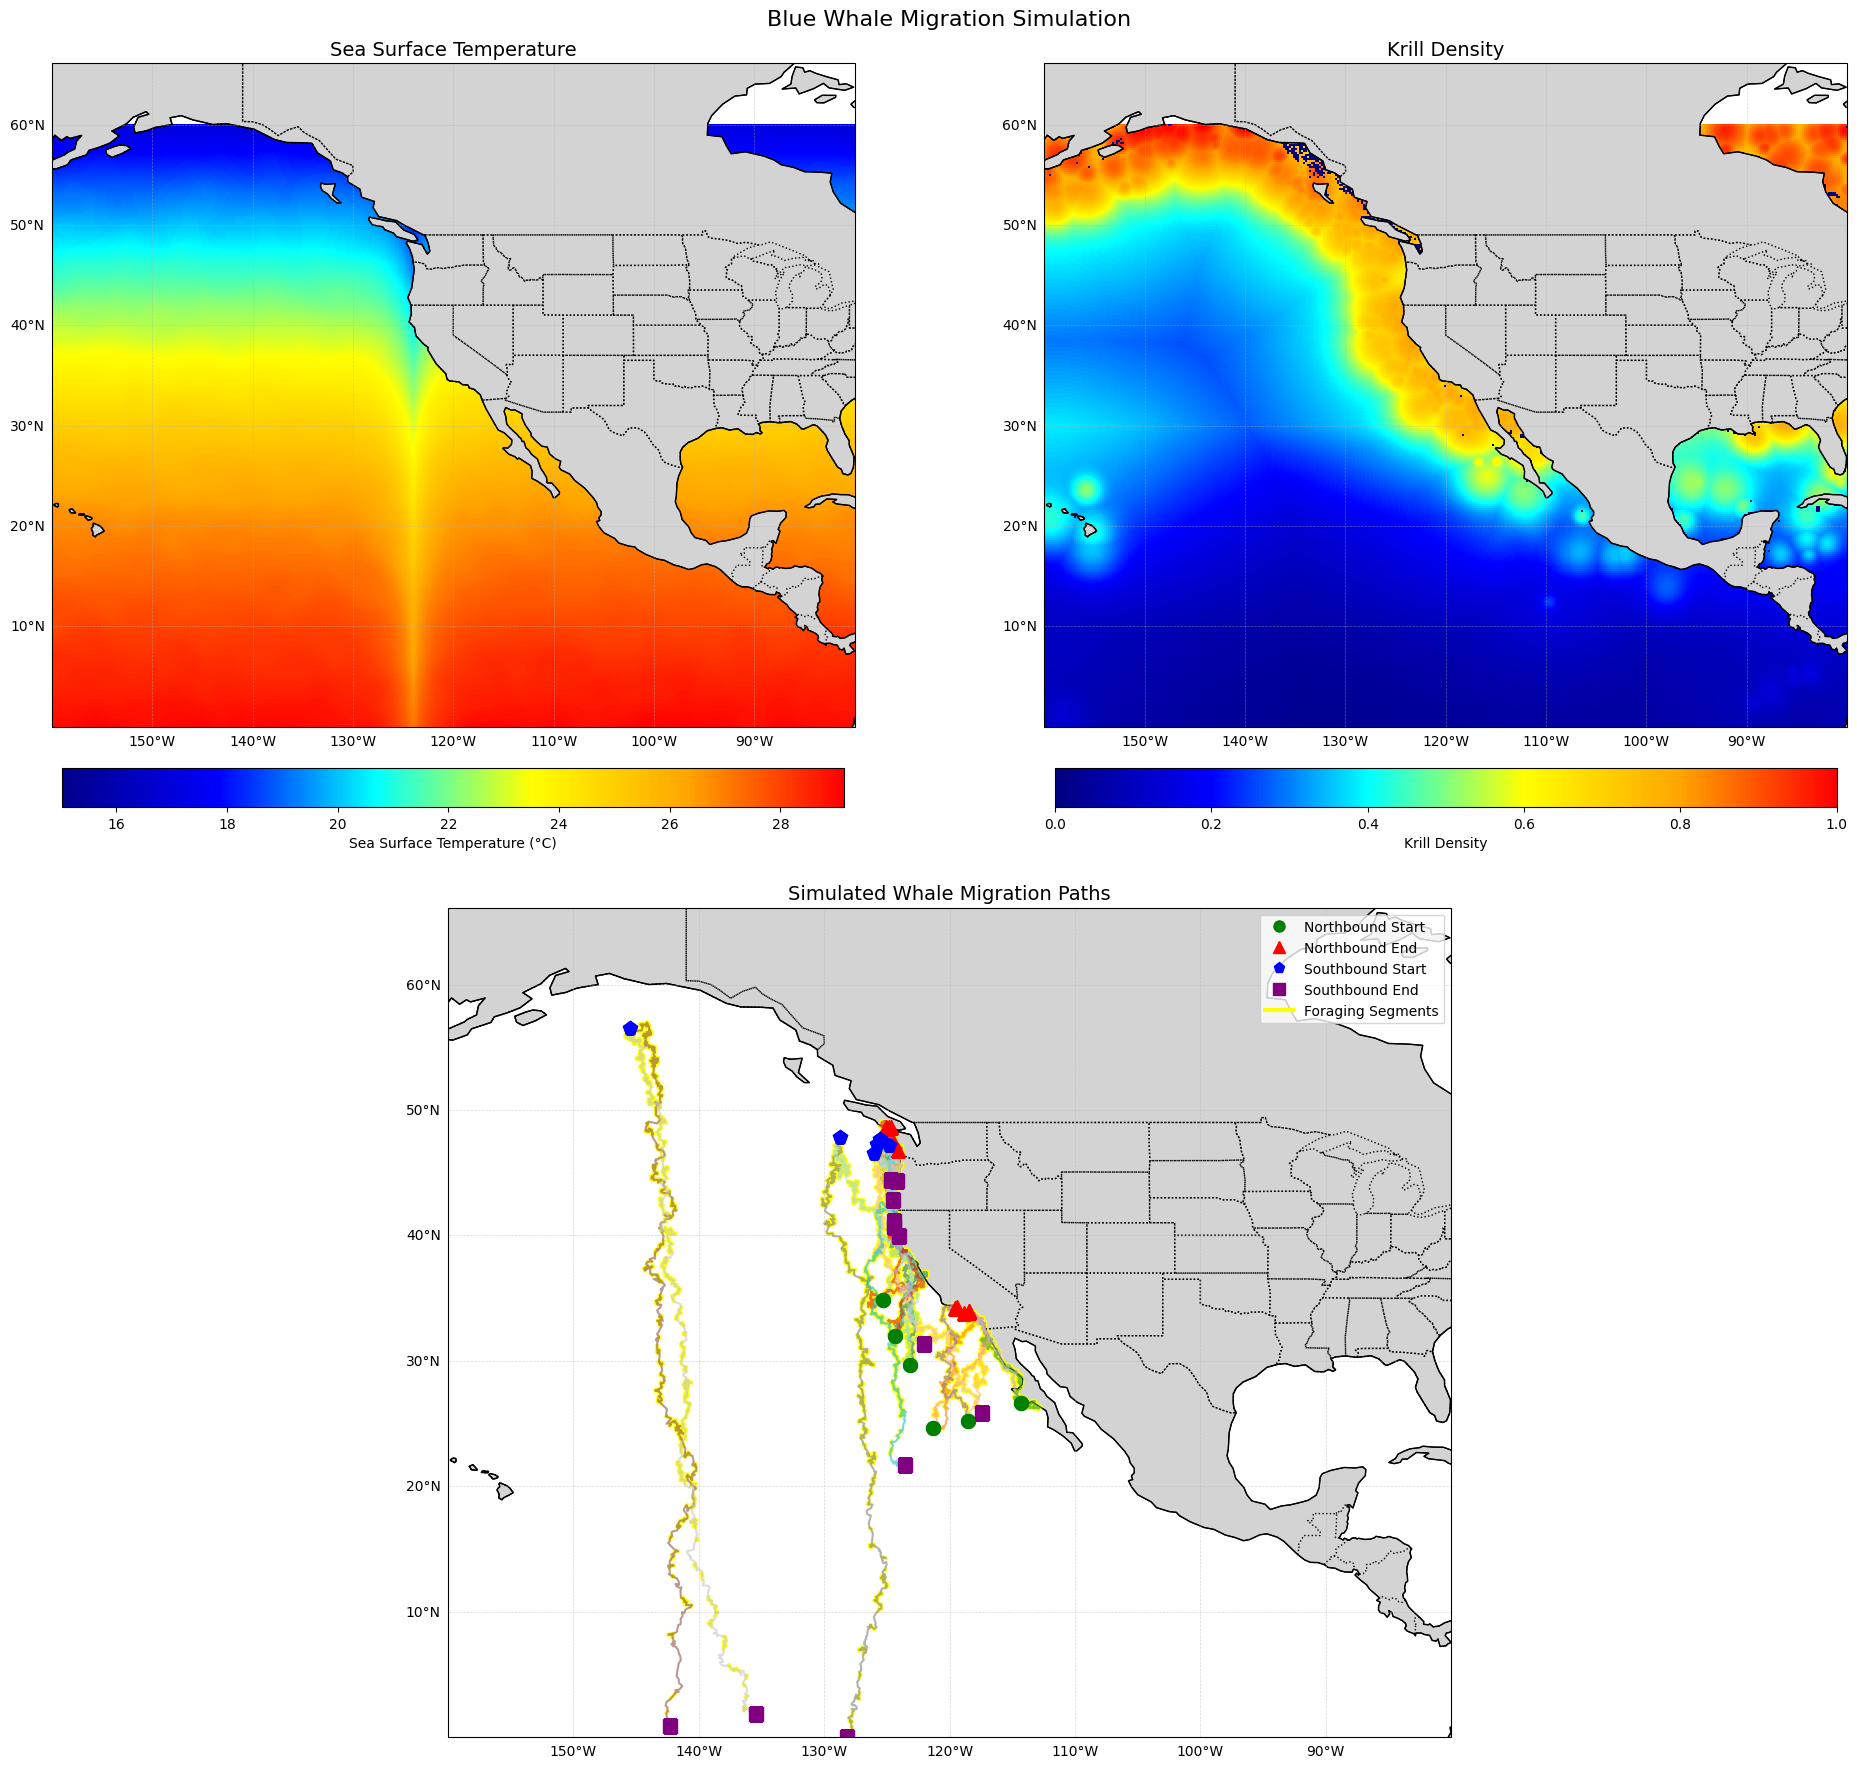

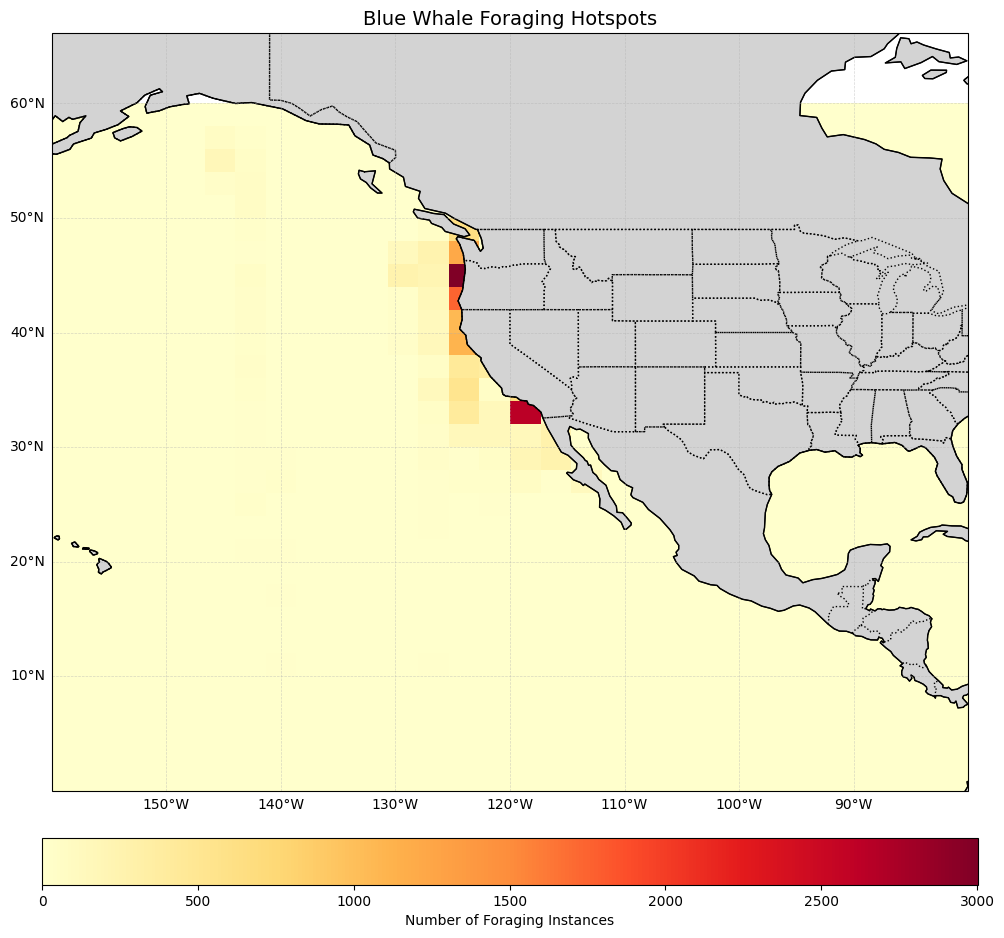

In [9]:
# Create whales with specific starting positions
def create_whales():
    whales = []

    # Northbound whales' coordinates
    north_coords = [
        (29.70, -123.14),
        (31.98, -124.33),
        (34.84, -125.31),
        (24.66, -121.32),
        (25.23, -118.52),
        (26.61, -114.33),
        (29.70, -123.14),
        (31.98, -124.33),
        (34.84, -125.31),
        (24.66, -121.32),
        (25.23, -118.52),
        (26.61, -114.33)
    ]

    # Southbound whales' coordinates
    south_coords = [
        (56.56, -145.45),
        (46.57, -126.00),
        (47.68, -125.52),
        (47.30, -125.75),
        (47.17, -124.85),
        (47.83, -128.74),
        (56.56, -145.45),
        (46.57, -126.00),
        (47.68, -125.52),
        (47.30, -125.75),
        (47.17, -124.85),
        (47.83, -128.74),
    ]

    # Create northbound whales
    whale_id = 0
    for lat, lon in north_coords:
        whale = Whale([lat, lon], state=1, whale_id=whale_id, north_to_south=False)
        whales.append(whale)
        whale_id += 1

    # Create southbound whales
    for lat, lon in south_coords:
        whale = Whale([lat, lon], state=1, whale_id=whale_id, north_to_south=True)
        whales.append(whale)
        whale_id += 1

    return whales

# Main simulation function
def run_simulation(whales, num_steps):
    print("Running whale migration simulation...")

    for step in range(num_steps):
        if step % 100 == 0:
            print(f"Step {step}/{num_steps}")

        for whale in whales:
            old_position = whale.position.copy()
            whale.move()

            # Get indices for checking land mask
            lat_idx = np.abs(lat_range - whale.position[0]).argmin()
            lon_idx = np.abs(lon_range - whale.position[1]).argmin()

            # Ensure indices are in bounds
            lat_idx = np.clip(lat_idx, 0, LAT_SIZE-1)
            lon_idx = np.clip(lon_idx, 0, LON_SIZE-1)

            # Check if new position is on land
            if land_mask[lat_idx, lon_idx]:
                # Revert to previous position if on land
                whale.position = old_position
                whale.path[-1] = tuple(old_position)  # Update the last point in the path

# Function to print whale statistics
def print_whale_stats(whales):
    print("\nWhale Migration Statistics:")
    print("--------------------------")

    for i, whale in enumerate(whales):
        direction = "Southward" if whale.north_to_south else "Northward"
        start_pos = whale.path[0]
        end_pos = whale.path[-1]
        distance = np.sum([np.linalg.norm(np.array(whale.path[j+1]) - np.array(whale.path[j]))
                           for j in range(len(whale.path)-1)])

        print(f"Whale {i} ({direction}):")
        print(f"  Start: ({start_pos[0]:.2f}°N, {start_pos[1]:.2f}°W)")
        print(f"  End: ({end_pos[0]:.2f}°N, {end_pos[1]:.2f}°W)")
        print(f"  Distance traveled: {distance:.2f}°")
        print(f"  Foraging time: {whale.forage_count/whale.step_count:.1%}")
        print(f"  Total krill encountered: {whale.total_krill_encountered:.4f}")
        print()

# Function to plot simulation results
def plot_results(whales):
    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(20, 18))

    # 1. SST Map
    ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([-160, -80, 0, 60])

    # Create SST colormap
    sst_cmap = LinearSegmentedColormap.from_list('sst_cmap',
                                               ['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'])

    # Plot SST (transpose to match lat/lon orientation for pcolormesh)
    cs1 = ax1.pcolormesh(lon_range, lat_range, sst, transform=ccrs.PlateCarree(),
                       cmap=sst_cmap, zorder=0)

    # Add land
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax1.add_feature(cfeature.STATES, linestyle=':', zorder=2)

    # Add colorbar
    cbar1 = plt.colorbar(cs1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar1.set_label('Sea Surface Temperature (°C)')

    # Add title
    ax1.set_title('Sea Surface Temperature', fontsize=14)

    # Add gridlines
    gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    # 2. Krill Density Map
    ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([-160, -80, 0, 60])

    # Create krill colormap
    krill_cmap = LinearSegmentedColormap.from_list('krill_cmap',
                                                 ['navy', 'blue', 'cyan', 'yellow', 'orange', 'red'])

    # Plot krill density
    cs2 = ax2.pcolormesh(lon_range, lat_range, krill_density, transform=ccrs.PlateCarree(),
                        cmap=krill_cmap, zorder=0)

    # Add land
    ax2.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
    ax2.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax2.add_feature(cfeature.STATES, linestyle=':', zorder=2)

    # Add colorbar
    cbar2 = plt.colorbar(cs2, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar2.set_label('Krill Density')

    # Add title
    ax2.set_title('Krill Density', fontsize=14)

    # Add gridlines
    gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl2.top_labels = False
    gl2.right_labels = False

    # 3. Whale Migration Paths
    ax3 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
    ax3.set_extent([-160, -80, 0, 60])

    # Plot whale migration paths
    num_whales = len(whales)
    colors = plt.cm.tab20(np.linspace(0, 1, num_whales))

    for i, whale in enumerate(whales):
        path = np.array(whale.path)

        # Color by whale ID
        color = colors[i]

        # Plot full path
        ax3.plot(path[:, 1], path[:, 0], '-', color=color, alpha=0.6, linewidth=1.5,
                transform=ccrs.PlateCarree(), zorder=3)

        # Plot start and end points with different colors/markers based on migration direction
        if whale.north_to_south:  # Southbound whales
            # Start point - pentagon in blue
            ax3.plot(path[0, 1], path[0, 0], 'p', color='blue', markersize=10,
                    transform=ccrs.PlateCarree(), zorder=4)
            # End point - square in purple
            ax3.plot(path[-1, 1], path[-1, 0], 's', color='purple', markersize=10,
                    transform=ccrs.PlateCarree(), zorder=4)
        else:  # Northbound whales
            # Start point - circle in green
            ax3.plot(path[0, 1], path[0, 0], 'o', color='green', markersize=10,
                    transform=ccrs.PlateCarree(), zorder=4)
            # End point - triangle in red
            ax3.plot(path[-1, 1], path[-1, 0], '^', color='red', markersize=10,
                    transform=ccrs.PlateCarree(), zorder=4)

        # Highlight foraging segments
        states = np.array(whale.states)
        foraging_indices = np.where(states == 2)[0]

        for idx in foraging_indices:
            if idx < len(path) - 1:  # Ensure there's a next point
                ax3.plot([path[idx, 1], path[idx+1, 1]], [path[idx, 0], path[idx+1, 0]],
                        '-', color='yellow', linewidth=3, alpha=0.7,
                        transform=ccrs.PlateCarree(), zorder=2)

    # Add land features
    ax3.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    ax3.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
    ax3.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax3.add_feature(cfeature.STATES, linestyle=':', zorder=2)

    # Add title
    ax3.set_title('Simulated Whale Migration Paths', fontsize=14)

    # Add gridlines
    gl3 = ax3.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl3.top_labels = False
    gl3.right_labels = False

    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', marker='o', linestyle='', markersize=8, label='Northbound Start'),
        Line2D([0], [0], color='red', marker='^', linestyle='', markersize=8, label='Northbound End'),
        Line2D([0], [0], color='blue', marker='p', linestyle='', markersize=8, label='Southbound Start'),
        Line2D([0], [0], color='purple', marker='s', linestyle='', markersize=8, label='Southbound End'),
        Line2D([0], [0], color='yellow', marker='', linestyle='-', linewidth=3, label='Foraging Segments')
    ]

    ax3.legend(handles=legend_elements, loc='upper right')

    # Add main title
    plt.suptitle('Blue Whale Migration Simulation', fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    return fig

# Function to plot foraging hotspots
def plot_foraging_hotspots(whales):
    """Create a heatmap of foraging locations."""
    foraging_locs = []

    for whale in whales:
        path = np.array(whale.path)
        states = np.array(whale.states)

        # Get locations where whale was foraging
        foraging_indices = np.where(states == 2)[0]
        if len(foraging_indices) > 0:
            foraging_locs.extend(path[foraging_indices].tolist())

    if foraging_locs:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.set_extent([-160, -80, 0, 60])

        # Create a 2D histogram of foraging locations
        foraging_locs = np.array(foraging_locs)
        H, xedges, yedges = np.histogram2d(
            foraging_locs[:, 1],  # Longitude
            foraging_locs[:, 0],  # Latitude
            bins=[30, 30],
            range=[[-160, -80], [0, 60]]
        )

        # Plot the histogram as a heatmap
        X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)
        cs = ax.pcolormesh(X, Y, H.T, cmap='YlOrRd', transform=ccrs.PlateCarree(), zorder=0)

        # Add land features
        ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
        ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
        ax.add_feature(cfeature.STATES, linestyle=':', zorder=2)

        # Add colorbar
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
        cbar.set_label('Number of Foraging Instances')

        # Add title
        plt.title('Blue Whale Foraging Hotspots', fontsize=14)

        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

        plt.tight_layout()
        plt.savefig('whale_foraging_hotspots.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create whales
whales = create_whales()

# Set number of simulation steps
num_steps = 1000

# Run the simulation
run_simulation(whales, num_steps)

# Print whale statistics
print_whale_stats(whales)

# Plot results
fig = plot_results(whales)
plt.show()

# Plot foraging hotspots
plot_foraging_hotspots(whales)

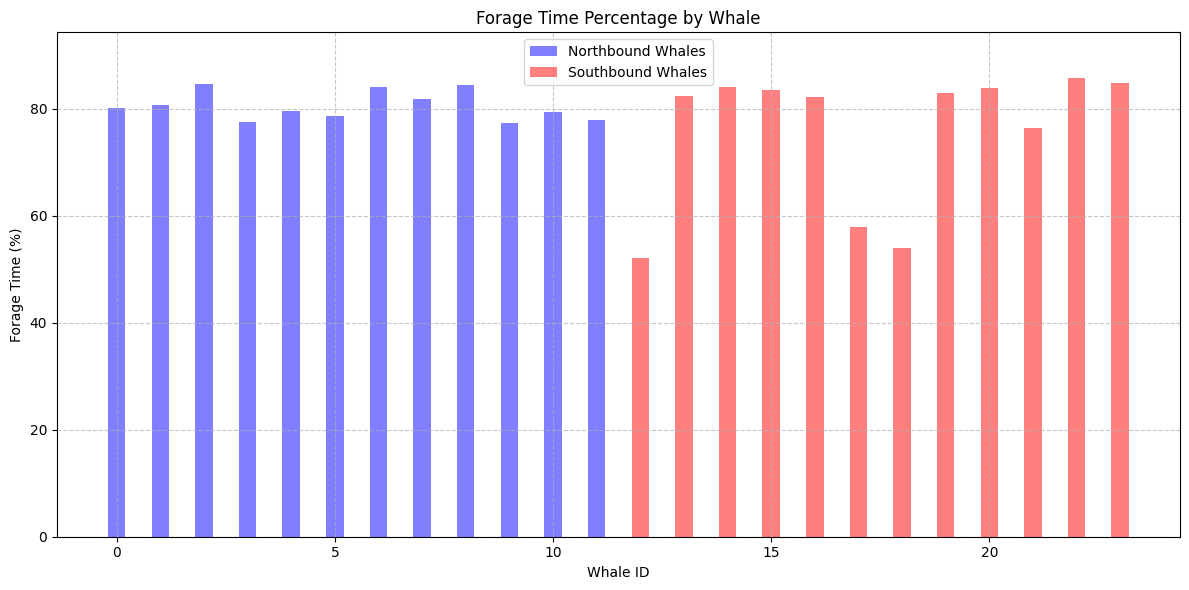

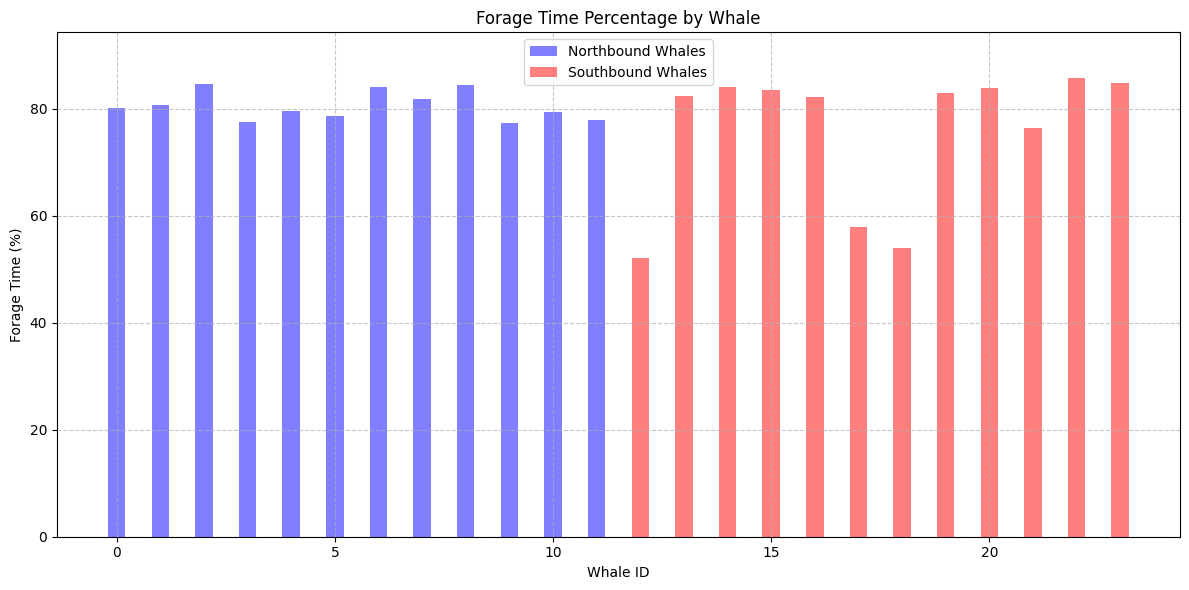

In [10]:
# Plot forage time bar graph
def plot_forage_time(whales):
    """Create a bar graph showing forage time percentage for each whale."""
    # Lists to store whale IDs and forage times
    north_ids = []
    north_forage_times = []
    south_ids = []
    south_forage_times = []

    # Separate whales by direction
    for i, whale in enumerate(whales):
        forage_time = whale.forage_count / whale.step_count * 100  # Convert to percentage

        if whale.north_to_south:  # Southbound
            south_ids.append(i)
            south_forage_times.append(forage_time)
        else:  # Northbound
            north_ids.append(i)
            north_forage_times.append(forage_time)

    # Create the figure
    fig, ax = plt.figure(figsize=(12, 6)), plt.gca()

    # Plot bars
    bar_width = 0.4

    # North whales (blue)
    ax.bar(north_ids, north_forage_times, bar_width,
           alpha=0.5, color='blue', label='Northbound Whales')

    # South whales (red)
    ax.bar(south_ids, south_forage_times, bar_width,
           alpha=0.5, color='red', label='Southbound Whales')

    # Add labels and title
    ax.set_xlabel('Whale ID')
    ax.set_ylabel('Forage Time (%)')
    ax.set_title('Forage Time Percentage by Whale')

    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

    # Set y-axis to percentage range
    ax.set_ylim(0, max(max(north_forage_times, default=0), max(south_forage_times, default=0)) * 1.1)

    plt.tight_layout()
    plt.savefig('whale_forage_time.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Plot forage time bar graph
plot_forage_time(whales)